In [1]:
# -*- coding:utf-8 -*- 
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,  Input
from keras import applications
from keras.callbacks import  Callback
from keras import optimizers
from keras.models import Model
import sys  
%matplotlib inline

Using TensorFlow backend.


In [2]:
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [3]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'wb'),bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'),bottleneck_features_validation)


In [9]:
save_bottlebeck_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [11]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_acc = []

        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

In [12]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    train_labels = np.array( [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    
    validation_labels = np.array( [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    return train_data ,train_labels,validation_data,validation_labels,model

In [13]:
train_data ,train_labels,validation_data,validation_labels,model = train_top_model()

In [14]:
history = LossHistory()

model.fit(train_data, train_labels, 
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks=[history],
          validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 33s - loss: 0.6364 - acc: 0.7720 - val_loss: 0.3972 - val_acc: 0.8200
Epoch 2/50
2000/2000 [==============================] - 0s - loss: 0.3373 - acc: 0.8610 - val_loss: 0.3206 - val_acc: 0.8688
Epoch 3/50
2000/2000 [==============================] - 0s - loss: 0.3028 - acc: 0.8845 - val_loss: 0.2428 - val_acc: 0.9025
Epoch 4/50
2000/2000 [==============================] - 0s - loss: 0.2548 - acc: 0.9045 - val_loss: 0.3026 - val_acc: 0.8950
Epoch 5/50
2000/2000 [==============================] - 0s - loss: 0.2328 - acc: 0.9150 - val_loss: 0.3399 - val_acc: 0.8800
Epoch 6/50
2000/2000 [==============================] - 0s - loss: 0.1895 - acc: 0.9265 - val_loss: 0.3199 - val_acc: 0.9000
Epoch 7/50
2000/2000 [==============================] - 0s - loss: 0.1936 - acc: 0.9255 - val_loss: 0.3337 - val_acc: 0.8938
Epoch 8/50
2000/2000 [==============================] - 0s - loss: 0.1599 - a

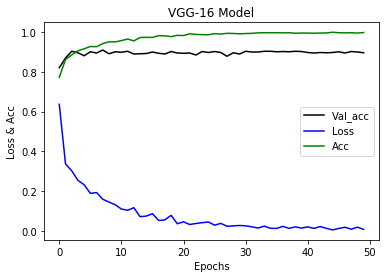

In [15]:
loss = history.losses
acc = history.acc
val_acc = history.val_acc


plt.xlabel('Epochs')
plt.ylabel('Loss & Acc')
plt.title('VGG-16 Model')

plt.plot(val_acc, 'black', label='Val_acc')
plt.plot(loss, 'blue', label='Loss')
plt.plot(acc, 'green', label='Acc')

plt.legend()
plt.show()

fine-tune

In [31]:
#weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 10
batch_size = 16

# build the VGG16 network
input_tensor = Input(shape=(img_width, img_height, 3))

base_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)
print('Model loaded.')

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(top_model_weights_path)


x = base_model.output
x = Flatten(weights=top_model.layers[0].get_weights())(x)
x = Dense(256, activation='relu',weights=top_model.layers[1].get_weights())(x)
x = Dropout(0.5,weights=top_model.layers[2].get_weights())(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid',weights=top_model.layers[3].get_weights())(x)



model = Model(inputs=base_model.input, outputs=predictions)



for layer in model.layers[:15]:
    layer.trainable = False
    
# add the model on top of the convolutional base
#model.add(top_model)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

Model loaded.


###  prepare data augmentation configuration

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


###  fine-tune the model

In [34]:
history = LossHistory()

model.fit_generator(
    generator=train_generator,
    steps_per_epoch=nb_train_samples ,
    epochs=10,
    callbacks=[history],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples)

Epoch 1/10
2000/2000 [==============================] - 514s - loss: 3.0635e-04 - acc: 0.9998 - val_loss: 0.5396 - val_acc: 0.9334
Epoch 2/10
2000/2000 [==============================] - 513s - loss: 1.2537e-04 - acc: 1.0000 - val_loss: 0.5341 - val_acc: 0.9400
Epoch 3/10
2000/2000 [==============================] - 515s - loss: 6.8741e-04 - acc: 0.9998 - val_loss: 0.5451 - val_acc: 0.9287
Epoch 4/10
2000/2000 [==============================] - 514s - loss: 5.9468e-04 - acc: 0.9997 - val_loss: 0.4978 - val_acc: 0.9404
Epoch 5/10
2000/2000 [==============================] - 515s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.4324 - val_acc: 0.9386
Epoch 6/10
2000/2000 [==============================] - 515s - loss: 0.0020 - acc: 0.9996 - val_loss: 0.4647 - val_acc: 0.9400
Epoch 7/10
2000/2000 [==============================] - 514s - loss: 3.4394e-04 - acc: 0.9999 - val_loss: 0.5133 - val_acc: 0.9437
Epoch 8/10
2000/2000 [==============================] - 514s - loss: 6.3384e-04 - acc: 0.99

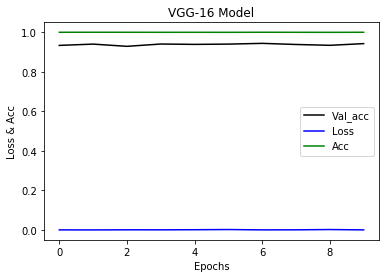

In [35]:
loss = history.losses
acc = history.acc
val_acc = history.val_acc


plt.xlabel('Epochs')
plt.ylabel('Loss & Acc')
plt.title('VGG-16 Model')

plt.plot(val_acc, 'black', label='Val_acc')
plt.plot(loss, 'blue', label='Loss')
plt.plot(acc, 'green', label='Acc')

plt.legend()
plt.show()